In [49]:
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline 

In [57]:
def flip(c):
    return '1' if(c == '0') else '0'

def gray2bin(gcstr):
    nbits = len(gcstr)  # number of bits in gcstr
    bstr = ""           # string containing the binary
    bstr = bstr + str(gcstr[0])
    
    for i in range(1,nbits):
       
        if gcstr[i] == '0':
            bstr = bstr + str(bstr[i-1])
        # If current Gray bit is 1, flip the
        # previous binary bit before adding
        else:
            bstr = bstr + str(flip(bstr[i-1]))
    return bstr

In [58]:
def flip_bit(bit):
    if bit==0:
        bit = 1
    else:
        bit = 0
    return bit

In [59]:
def init_bin(M,N,nbits):
    pop_chrom = np.random.randint(0,2,size=(M,nbits))
    return pop_chrom

def gen2phen(disc2decf,X,N,a,b,nbits_word):
    # nbits_dv - number of bits for each decision variable
    nbits_dv = int(nbits_word / N)
    inii = 0 # initial pointer for slicing X
    endi = nbits_dv # final pointer for slicing X
    Xdv = np.zeros(N) # array of decimal decision variables
    for ii in range(N):
        # binary representation of the ith decision variable
        bxdv = X[inii:endi]
        # convert bxdv to string
        xstr = np.array2string(bxdv, separator='')
        # remove the delimiting square brackets from xstr
        xstr = xstr[1:nbits_dv + 1]
        # convert from binary to decimal in the interval [a,b]
        dnum = disc2decf(xstr, a[ii], b[ii], nbits_dv)
        # store in the array of decision variables
        Xdv[ii] = dnum
        # update the pointers for the next iteration
        inii = endi
        endi = endi + nbits_dv
    return Xdv

In [60]:
def sphere(x):
    d = len(x)
    y = 0
    for ii in range(d):
        y = y + x[ii]**2
    return y

def fitness_sphere_gray(X,N,a,b,nbits_word):
    Xrv= gen2phen(gray2decInterval,X,N,a,b,nbits_word)
    fitness_value = -sphere(Xrv)
    return fitness_value

In [61]:
def gray2dec(gcstr):
    bstr =  gray2bin(gcstr)
    dnum = int(bstr, 2)
    return dnum

def gray2decInterval(gcstr, a, b, nbits_dv):
    # Step of the representation in base 10
    delta = (b - a) / (2 ** nbits_dv)
    # converts a gray coded string representing a number in given base to decimal.
    dnum =gray2dec(gcstr)
    # position dnum in [a,b]
    decnum = a + delta * dnum
    return decnum


In [62]:
def elitism(pop_chrom, pop_fit, children_chrom, children_fit, er):
    # Compute number of individuals in the population
    N = np.shape(pop_chrom)[0]
    # Compute number of elite chromosomes
    M = int(np.ceil(N * er))
    # Sort the N children in descending fitness order
    ids_sorted = np.argsort(-children_fit)
    # Keep only the best N - M children
    ids_sorted = ids_sorted[0:(N - M)]
    children_chrom = children_chrom[ids_sorted]
    children_fit = children_fit[ids_sorted]
    # Pick the best M individuals of the current population
    ids_sorted = np.argsort(-pop_fit)
    ids_sorted = ids_sorted[0:M]
    best_pop_chrom = pop_chrom[ids_sorted]
    best_pop_fit = pop_fit[ids_sorted]
    # Replace the worst M children with the M elite chromosomes of the
    # last generation
    new_pop_chrom = np.vstack((children_chrom, best_pop_chrom))
    new_pop_fit = np.hstack((children_fit,best_pop_fit))
    # Return the new population and the corresponding fitness values
    return new_pop_chrom, new_pop_fit

In [63]:
def crossover_dp(parent1_chrom, parent2_chrom, pc):
    # Compute the range of valid crossing points
    valid_cp = np.arange(1,len(parent1_chrom))
    # Sample two crossing points from valid_cp without repetition
    samples = np.random.choice(valid_cp, 2, replace=False)
    cross_pt1 = samples[0]
    cross_pt2 = samples[1]
    # Make sure that cross_pt1 < cross_pt2
    if cross_pt1 > cross_pt2:
        temp = cross_pt1
        cross_pt1 = cross_pt2
        cross_pt2 = temp
    # First child
    part1 = parent1_chrom[0:cross_pt1]
    part2 = parent2_chrom[cross_pt1:cross_pt2]
    part3 = parent1_chrom[cross_pt2:]
    child1 = np.concatenate((part1, part2, part3))
    # Second child
    part1 = parent2_chrom[0:cross_pt1]
    part2 = parent1_chrom[cross_pt1:cross_pt2]
    part3 = parent2_chrom[cross_pt2:]
    child2 = np.concatenate((part1, part2, part3))
    # Decide if recombined children make it to the next generation
    R1 = np.random.uniform()
    if R1 > pc:
        child1 = parent1_chrom  # do not recombinate
    R2 = np.random.uniform()
    if R2 > pc:
        child2 = parent2_chrom  # do not recombinate
    # Return the offspring
    return child1, child2

In [64]:

def mutation_binary(x, pm):
    # if pm=0, no mutation is performed
    if pm == 0:
        return x
    # Compute the number of genes in x
    M = np.size(x)
    # This is because in Python arguments are passed
    # by reference, not by value
    mutated_x = np.copy(x)
    # Mutate each gene
    for k in range(M):
        r = np.random.uniform()
        if r < pm:
            mutated_x[k] = flip_bit(x[k])
    # Return mutated individual
    return mutated_x

In [65]:
def gab(N,maxIters,pc,pm,er,ffitness,fsel,fcross,fmutation,lb,ub,nbits_word):
    numVar = np.shape(lb)[0]
    pop_chrom= init_bin(N, numVar,nbits_word)
    
    pop_fit = np.zeros(N)
    for i in range(N):
        pop_fit[i]=ffitness(pop_chrom[i],numVar, lb,ub,nbits_word)
        
    for id_iter in range(maxIters):
        children_chrom = np.zeros((N,nbits_word ),dtype=int)
        children_fit= np.zeros(N)
        for k in range(0,N):
            parent1_chrom, parent2_chrom = fsel(pop_chrom,pop_fit)
            child_chrom,_= fcross(parent1_chrom, parent2_chrom,pc)
            child_chrom= fmutation(child_chrom,pm)
            children_chrom[k]=child_chrom
            
        for j in range(N):
            children_fit[j] = ffitness(children_chrom[j],numVar, lb,ub,nbits_word)
    
        new_pop_chrom, new_pop_fit= elitism(pop_chrom, pop_fit, children_chrom,children_fit,er)
        pop_chrom = np.copy(new_pop_chrom)
        pop_fit= np.copy(new_pop_fit)
    
        ids_sorted = np.argsort(-pop_fit)
        ind_best =ids_sorted[0]
        if id_iter ==0:
            best_fits_history = np.array([pop_fit[ind_best]])
            bestSol = np.array([pop_chrom[ind_best]])
        else:
            best_fits_history= np.vstack((best_fits_history,pop_fit[ind_best]))
            bestSol = np.vstack((bestSol,pop_chrom[ind_best]))
        
    ind_best= np.argmax(pop_fit)
    best_chrom= pop_chrom[ind_best]
    return best_chrom, best_fits_history

In [66]:
def plot_convergence_curve(fig_name,title_str,fbest_h,fig_size_x = 8,fig_size_y = 4, dpi=1000):
    num_vals = len(fbest_h)
    t = np.linspace(0, num_vals-1, num_vals)
    fig, ax = plt.subplots(figsize=(fig_size_x,fig_size_y), dpi=dpi) # figura 800x600 pixels
    ax.plot(t, fbest_h,c='0.35')
    ax.set_xlabel(r'$\mathit{iteration}$')
    ax.set_ylabel(r'$f_o$')
    ax.set_title(title_str)
    ax.grid(True)
    plt.savefig(fig_name,format="eps",dpi=dpi)

In [67]:
ndim=20
lb= -5*np.ones(ndim)
ub= 5*np.ones(ndim)
nbits_var=4
nbits_word= ndim+nbits_var
npop=30
maxIter=300


pc=0.8
pm=0.1
er=0.1
maxIters=300
crossoverf= crossover_dp
mutationf= mutation_binary
selectionf= selection_tournament
fitenessf= fitness_sphere_gray

best_theta, best_scores = gab(npop,maxIters,pc,pm,er,fitenessf,selectionf,crossoverf,mutationf,lb,ub,nbits_word)

best_theta=gen2phen(gray2decInterval, best_theta,ndim,lb,ub,nbits_word)
best_scores= np.squeeze(best_scores)



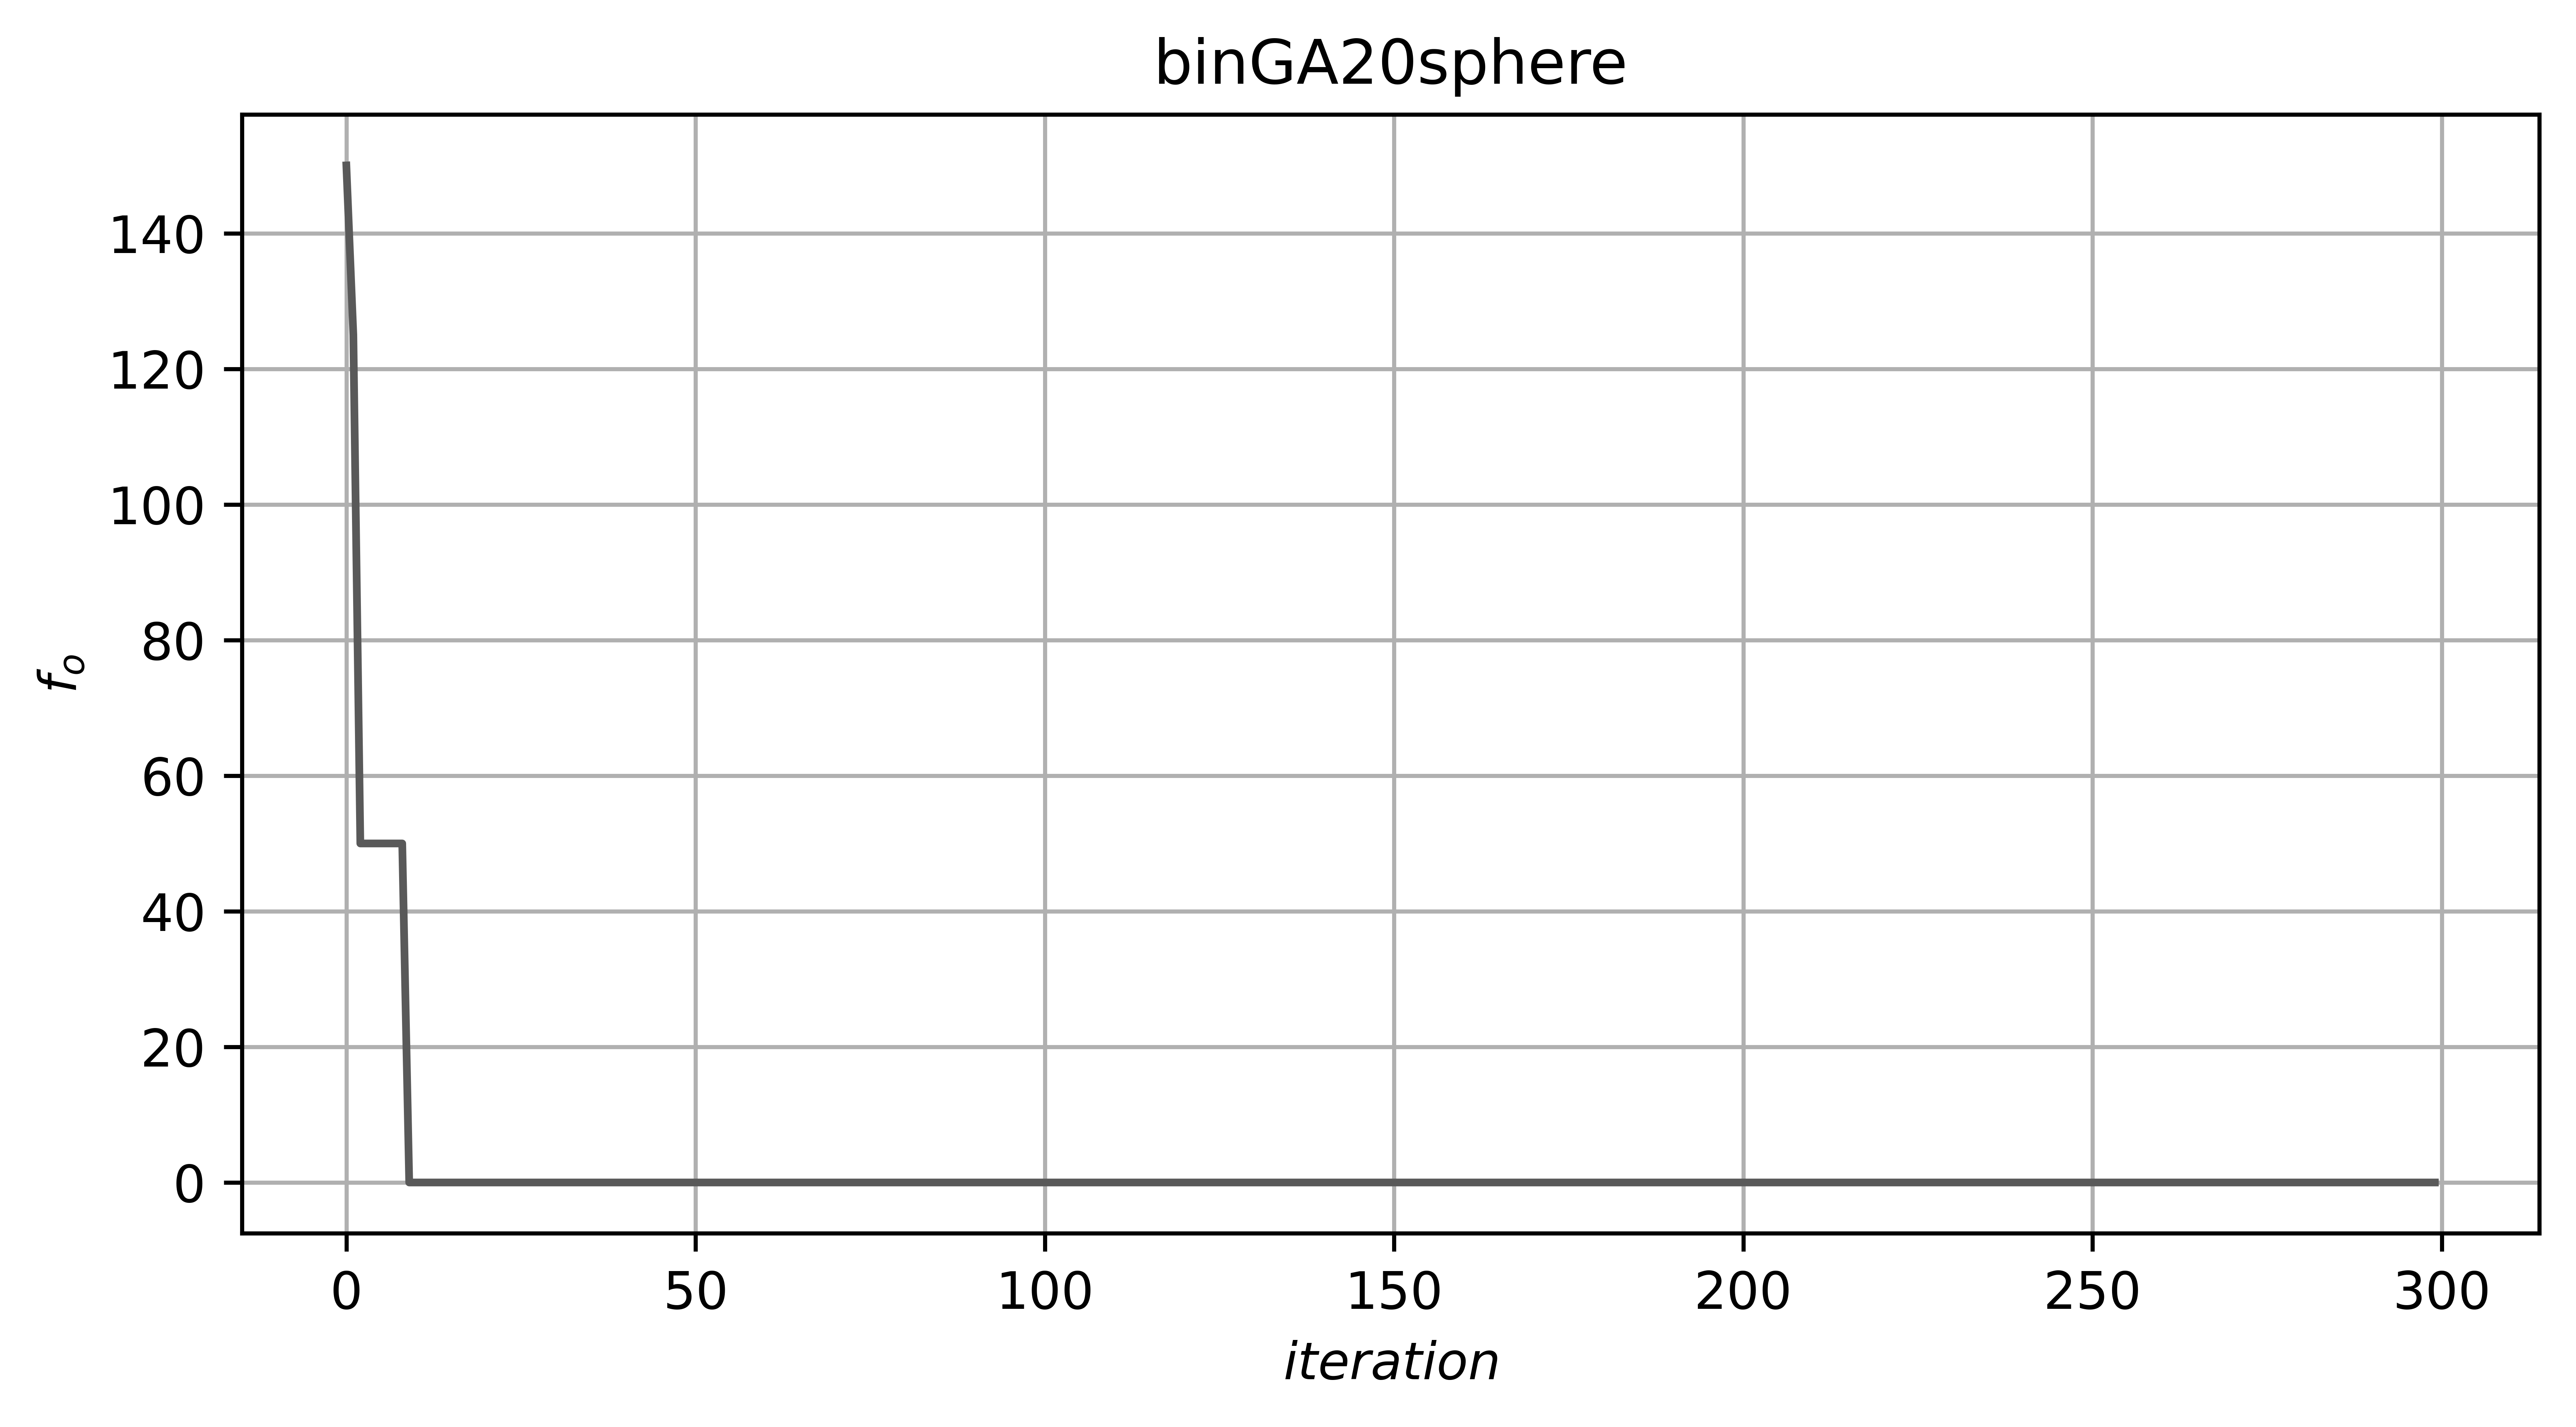

In [68]:
fig_file= "figb1.png"
title_str= "binGA"+ str(ndim)+"sphere"
plot_convergence_curve(fig_file,title_str,-best_scores)

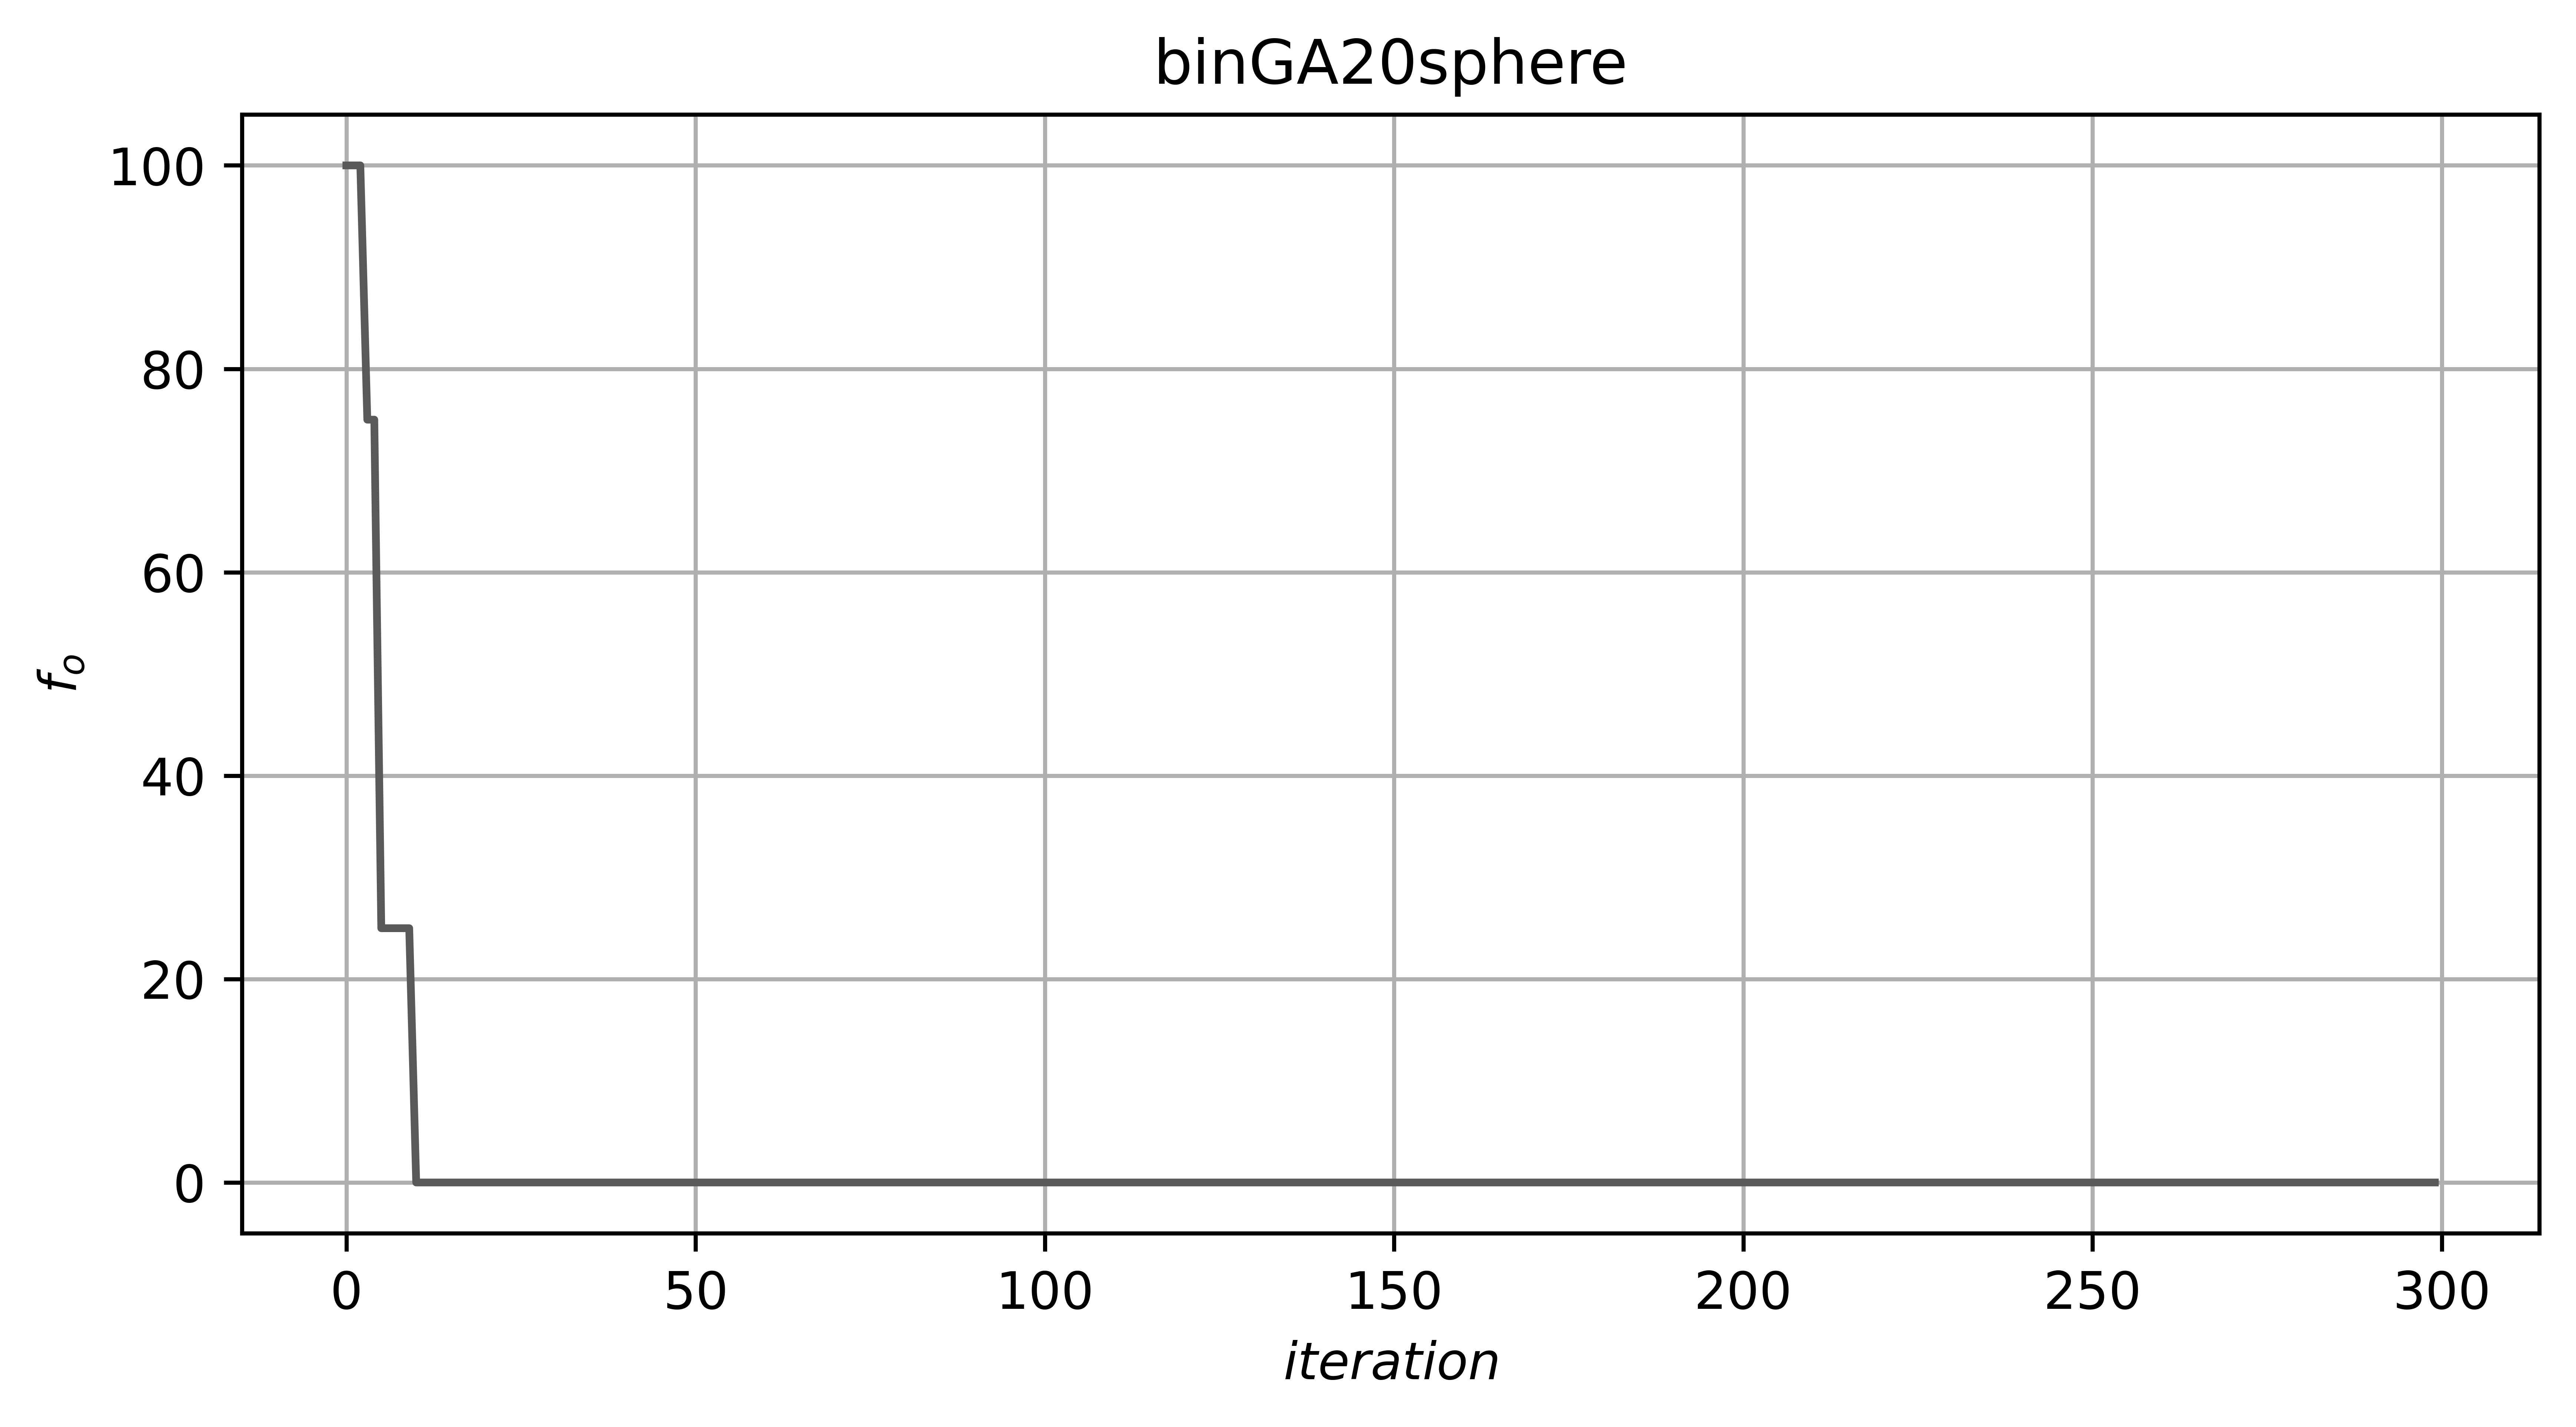